In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import metrics
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [2]:
df = pd.read_csv('../Data/single_affect.csv')

In [3]:
df

,assignment_action_id,assignment_log_id,student_user_xid,action_time,action_name,action_name-2,extended_action_name,answer_text,answer_correctness,seconds_since_last_action,teacher_xid,category_name,teacher_feedback
0,4860597,122949,41904,22:46.7,StudentResponseAction,StudentResponseAction,StudentResponseAction_false,Figure 2,0.0,56.466,8926,Thoughtful self correcting,Great job sticking with it until you got the r...
1,4860724,122949,41904,23:05.1,StudentResponseAction,StudentResponseAction,StudentResponseAction_false,"Figure 1 , Figure 2 , Figure 4",0.0,18.460,8926,Thoughtful self correcting,Great job sticking with it until you got the r...
2,4860830,122949,41904,23:31.5,StudentResponseAction,StudentResponseAction,StudentResponseAction_true,"Figure 2 , Figure 4",1.0,26.400,8926,Thoughtful self correcting,Great job sticking with it until you got the r...
3,5860191,122952,41905,29:00.1,StudentResponseAction,StudentResponseAction,StudentResponseAction_false,4,0.0,10.902,8926,Thoughtful self correcting,Great job rethinking the problem and getting i...
4,5860374,122952,41905,29:43.2,StudentResponseAction,StudentResponseAction,StudentResponseAction_true,0.25,1.0,43.011,8926,Thoughtful self correcting,Great job rethinking the problem and getting i...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8144,306725278,6753436,1203697,35:46.2,StudentResponseAction,StudentResponseAction,StudentResponseAction_true,B. No,1.0,5.535,8926,Fast correct response,Good job getting the answer correct. Make sur...
8145,309061379,6800608,1271140,49:54.5,StudentResponseAction,StudentResponseAction,StudentResponseAction_true,B. No,1.0,9.356,8926,Thoughtful Correct Response,I like how you took your time and thought thro...
8146,309382815,6818428,1164303,33:12.6,StudentResponseAction,StudentResponseAction,StudentResponseAction_false,A. Yes,0.0,17.242,8926,Guessing after first attempt,Looks like you took your time and thought thro...
8147,309383988,6818428,1164303,33:18.7,StudentResponseAction,StudentResponseAction,StudentResponseAction_false,C. Not enough information,0.0,6.147,8926,Guessing after first attempt,Looks like you took your time and thought thro...


# Preprocess to set all answer texts to None when not StudentResponseAction

In [4]:
df.answer_text.value_counts(dropna=False)

NaN              1001
4                 124
2                 105
2-Jan              97
3                  93
                 ... 
1/2 (6x-10)-x       1
4.64                1
$980.00             1
1 , 3 , 5           1
6,2                 1
Name: answer_text, Length: 1683, dtype: int64

In [5]:
df.loc[df.action_name != "StudentResponseAction", "answer_text"] = None

In [6]:
print(df.answer_text.to_string())

0                                                Figure 2
1                          Figure 1 , Figure 2 , Figure 4
2                                     Figure 2 , Figure 4
3                                                       4
4                                                    0.25
5                                     Figure 2 , Figure 4
6                                                Figure 4
7                                     Figure 1 , Figure 4
8                          Figure 1 , Figure 2 , Figure 4
9               Figure 1 , Figure 2 , Figure 3 , Figure 4
10                                                   None
11                                    Figure 2 , Figure 4
12                                                      3
13                                                    1.5
14                                                   None
15                                    Figure 2 , Figure 4
16                                                     18
17            

In [7]:
df.answer_text.value_counts(dropna=False)

NaN                                                        1041
4                                                           124
2                                                           105
2-Jan                                                        97
3                                                            92
                                                           ... 
$980.00                                                       1
0/3                                                           1
x-(10-6x)1/2                                                  1
3.25                                                          1
12 + (0.25 * 12) , 12(1 + 0.25) , 12 * 0.25 , 12 + 0.25       1
Name: answer_text, Length: 1666, dtype: int64

There are 40 instances of answer_text that have now been made NaN

# Preprocess to create label: 1 if Thoughtful self correcting 0 otherwise

In [8]:
df.category_name.value_counts()

Struggled and requested answer                                                                 1257
Thoughtful self correcting                                                                     1177
Thoughtful Correct Response                                                                    1039
Guessing after first attempt and gave up                                                        742
Gave up after first attempt                                                                     597
Gave up after two attempts                                                                      527
Guessing after first attempt                                                                    447
Fast self correcting                                                                            442
No attempt                                                                                      415
Struggled and persevered                                                                        315


In [9]:
(df.category_name == 'Thoughtful self correcting').astype(int).value_counts()

0    6972
1    1177
Name: category_name, dtype: int64

In [10]:
df['label'] = (df.category_name == 'Thoughtful self correcting').astype(int)

In [11]:
df

,assignment_action_id,assignment_log_id,student_user_xid,action_time,action_name,action_name-2,extended_action_name,answer_text,answer_correctness,seconds_since_last_action,teacher_xid,category_name,teacher_feedback,label
0,4860597,122949,41904,22:46.7,StudentResponseAction,StudentResponseAction,StudentResponseAction_false,Figure 2,0.0,56.466,8926,Thoughtful self correcting,Great job sticking with it until you got the r...,1
1,4860724,122949,41904,23:05.1,StudentResponseAction,StudentResponseAction,StudentResponseAction_false,"Figure 1 , Figure 2 , Figure 4",0.0,18.460,8926,Thoughtful self correcting,Great job sticking with it until you got the r...,1
2,4860830,122949,41904,23:31.5,StudentResponseAction,StudentResponseAction,StudentResponseAction_true,"Figure 2 , Figure 4",1.0,26.400,8926,Thoughtful self correcting,Great job sticking with it until you got the r...,1
3,5860191,122952,41905,29:00.1,StudentResponseAction,StudentResponseAction,StudentResponseAction_false,4,0.0,10.902,8926,Thoughtful self correcting,Great job rethinking the problem and getting i...,1
4,5860374,122952,41905,29:43.2,StudentResponseAction,StudentResponseAction,StudentResponseAction_true,0.25,1.0,43.011,8926,Thoughtful self correcting,Great job rethinking the problem and getting i...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8144,306725278,6753436,1203697,35:46.2,StudentResponseAction,StudentResponseAction,StudentResponseAction_true,B. No,1.0,5.535,8926,Fast correct response,Good job getting the answer correct. Make sur...,0
8145,309061379,6800608,1271140,49:54.5,StudentResponseAction,StudentResponseAction,StudentResponseAction_true,B. No,1.0,9.356,8926,Thoughtful Correct Response,I like how you took your time and thought thro...,0
8146,309382815,6818428,1164303,33:12.6,StudentResponseAction,StudentResponseAction,StudentResponseAction_false,A. Yes,0.0,17.242,8926,Guessing after first attempt,Looks like you took your time and thought thro...,0
8147,309383988,6818428,1164303,33:18.7,StudentResponseAction,StudentResponseAction,StudentResponseAction_false,C. Not enough information,0.0,6.147,8926,Guessing after first attempt,Looks like you took your time and thought thro...,0


# Process 'seconds_since_last_action'

In [12]:
df.seconds_since_last_action.isna().value_counts() # Check if any are na to fill with 0

False    8149
Name: seconds_since_last_action, dtype: int64

<AxesSubplot:xlabel='action_name', ylabel='seconds_since_last_action'>

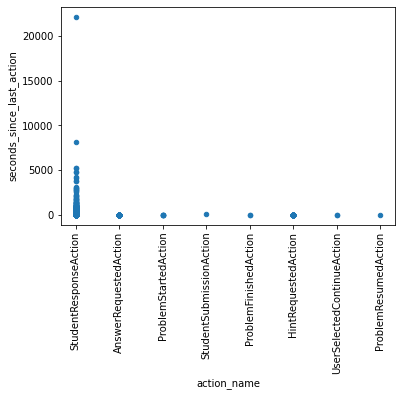

In [13]:
df[['action_name', 'seconds_since_last_action']].plot.scatter(x='action_name', y='seconds_since_last_action', rot=90)

TODO: is there any processing needed here?

# Subset dataset to get features

In [14]:
data_subset = df[['seconds_since_last_action', 'label']]

In [15]:
data_subset

,seconds_since_last_action,label
0,56.466,1
1,18.460,1
2,26.400,1
3,10.902,1
4,43.011,1
...,...,...
8144,5.535,0
8145,9.356,0
8146,17.242,0
8147,6.147,0


In [16]:
pd.get_dummies(df.extended_action_name)

,AnswerRequestedAction_,HintRequestedAction_false,HintRequestedAction_true,ProblemFinishedAction_false,ProblemFinishedAction_true,ProblemResumedAction_,ProblemStartedAction_false,ProblemStartedAction_true,StudentResponseAction_false,StudentResponseAction_true,StudentSubmissionAction_true,UserSelectedContinueAction_
0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8144,0,0,0,0,0,0,0,0,0,1,0,0
8145,0,0,0,0,0,0,0,0,0,1,0,0
8146,0,0,0,0,0,0,0,0,1,0,0,0
8147,0,0,0,0,0,0,0,0,1,0,0,0


In [17]:
pd.concat([pd.get_dummies(df['extended_action_name']), data_subset], axis=1)

,AnswerRequestedAction_,HintRequestedAction_false,HintRequestedAction_true,ProblemFinishedAction_false,ProblemFinishedAction_true,ProblemResumedAction_,ProblemStartedAction_false,ProblemStartedAction_true,StudentResponseAction_false,StudentResponseAction_true,StudentSubmissionAction_true,UserSelectedContinueAction_,seconds_since_last_action,label
0,0,0,0,0,0,0,0,0,1,0,0,0,56.466,1
1,0,0,0,0,0,0,0,0,1,0,0,0,18.460,1
2,0,0,0,0,0,0,0,0,0,1,0,0,26.400,1
3,0,0,0,0,0,0,0,0,1,0,0,0,10.902,1
4,0,0,0,0,0,0,0,0,0,1,0,0,43.011,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8144,0,0,0,0,0,0,0,0,0,1,0,0,5.535,0
8145,0,0,0,0,0,0,0,0,0,1,0,0,9.356,0
8146,0,0,0,0,0,0,0,0,1,0,0,0,17.242,0
8147,0,0,0,0,0,0,0,0,1,0,0,0,6.147,0


input shape has 13 columns (exclude label)

# Stratify dataset by student id

In [18]:
unique_students = df.student_user_xid.unique()
np.random.shuffle(unique_students)

In [19]:
students_tenfold = np.array_split(unique_students, 10)

In [20]:
def holdout_split(holdout, df):
    test = df[df.student_user_xid.isin(students_tenfold[holdout])]
    
    train = students_tenfold[:holdout] + students_tenfold[holdout+1:]
    train = [val for sublist in train for val in sublist]
    train = df[df.student_user_xid.isin(train)]
    
    return (test, train)

# grouping timeseries by assignment_log_id

In [21]:
input_cols = 13
def create_xy(df):
    groupeddf = df.groupby('assignment_log_id').agg(lambda x: x.tolist())
    del groupeddf['student_user_xid']
    
    X = groupeddf.iloc[:,:-1].to_numpy()
    y = groupeddf.iloc[:, -1:].to_numpy()
    
    XT = [np.array([np.array(xii) for xii in xi]).reshape((input_cols,-1)).T for xi in X]
    yt = [np.array([np.array(yii) for yii in yi]).reshape((1,-1)).T for yi in y]
    
    return (XT, yt)

# Create and run lstm

In [24]:
n_units = 50
n_epochs = 200
batch_size = 50
val_split = 0.2

Epoch 1/200
46/46 [==============================] - 3s 22ms/step - loss: 0.4937 - val_loss: 0.0564

Epoch 00001: val_loss improved from inf to 0.05641, saving model to best_model.h5
Epoch 2/200
46/46 [==============================] - 1s 11ms/step - loss: 0.0562 - val_loss: 0.0493

Epoch 00002: val_loss improved from 0.05641 to 0.04934, saving model to best_model.h5
Epoch 3/200
46/46 [==============================] - 1s 16ms/step - loss: 0.0521 - val_loss: 0.0475

Epoch 00003: val_loss improved from 0.04934 to 0.04750, saving model to best_model.h5
Epoch 4/200
46/46 [==============================] - 1s 16ms/step - loss: 0.0445 - val_loss: 0.0462

Epoch 00004: val_loss improved from 0.04750 to 0.04619, saving model to best_model.h5
Epoch 5/200
46/46 [==============================] - 1s 18ms/step - loss: 0.0472 - val_loss: 0.0449

Epoch 00005: val_loss improved from 0.04619 to 0.04489, saving model to best_model.h5
Epoch 6/200
46/46 [==============================] - 1s 12ms/step - l

46/46 [==============================] - 0s 9ms/step - loss: 0.0269 - val_loss: 0.0277

Epoch 00045: val_loss did not improve from 0.02742
Epoch 46/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0250 - val_loss: 0.0271

Epoch 00046: val_loss improved from 0.02742 to 0.02711, saving model to best_model.h5
Epoch 47/200
46/46 [==============================] - 0s 9ms/step - loss: 0.0269 - val_loss: 0.0269

Epoch 00047: val_loss improved from 0.02711 to 0.02693, saving model to best_model.h5
Epoch 48/200
46/46 [==============================] - 0s 9ms/step - loss: 0.0253 - val_loss: 0.0271

Epoch 00048: val_loss did not improve from 0.02693
Epoch 49/200
46/46 [==============================] - 0s 9ms/step - loss: 0.0260 - val_loss: 0.0267

Epoch 00049: val_loss improved from 0.02693 to 0.02665, saving model to best_model.h5
Epoch 50/200
46/46 [==============================] - 0s 9ms/step - loss: 0.0255 - val_loss: 0.0266

Epoch 00050: val_loss improved from 0.02665 to

46/46 [==============================] - 0s 9ms/step - loss: 0.0226 - val_loss: 0.0244

Epoch 00095: val_loss did not improve from 0.02420
Epoch 96/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0245 - val_loss: 0.0243

Epoch 00096: val_loss did not improve from 0.02420
Epoch 97/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0229 - val_loss: 0.0244

Epoch 00097: val_loss did not improve from 0.02420
Epoch 98/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0226 - val_loss: 0.0245

Epoch 00098: val_loss did not improve from 0.02420
Epoch 99/200
46/46 [==============================] - 0s 9ms/step - loss: 0.0235 - val_loss: 0.0244

Epoch 00099: val_loss did not improve from 0.02420
Epoch 100/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0230 - val_loss: 0.0241

Epoch 00100: val_loss improved from 0.02420 to 0.02405, saving model to best_model.h5
Epoch 101/200
46/46 [==============================] - 0s 9ms

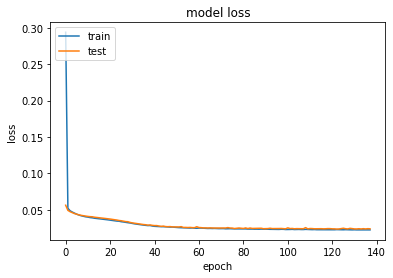

Epoch 1/200
46/46 [==============================] - 4s 33ms/step - loss: 0.4509 - val_loss: 0.0584

Epoch 00001: val_loss improved from inf to 0.05842, saving model to best_model.h5
Epoch 2/200
46/46 [==============================] - 1s 12ms/step - loss: 0.0551 - val_loss: 0.0500

Epoch 00002: val_loss improved from 0.05842 to 0.05003, saving model to best_model.h5
Epoch 3/200
46/46 [==============================] - 1s 13ms/step - loss: 0.0498 - val_loss: 0.0475

Epoch 00003: val_loss improved from 0.05003 to 0.04748, saving model to best_model.h5
Epoch 4/200
46/46 [==============================] - 0s 11ms/step - loss: 0.0468 - val_loss: 0.0458

Epoch 00004: val_loss improved from 0.04748 to 0.04582, saving model to best_model.h5
Epoch 5/200
46/46 [==============================] - 1s 11ms/step - loss: 0.0448 - val_loss: 0.0446

Epoch 00005: val_loss improved from 0.04582 to 0.04460, saving model to best_model.h5
Epoch 6/200
46/46 [==============================] - 0s 10ms/step - l

46/46 [==============================] - 1s 11ms/step - loss: 0.0260 - val_loss: 0.0268

Epoch 00045: val_loss improved from 0.02745 to 0.02682, saving model to best_model.h5
Epoch 46/200
46/46 [==============================] - 1s 12ms/step - loss: 0.0260 - val_loss: 0.0264

Epoch 00046: val_loss improved from 0.02682 to 0.02638, saving model to best_model.h5
Epoch 47/200
46/46 [==============================] - 1s 13ms/step - loss: 0.0256 - val_loss: 0.0264

Epoch 00047: val_loss did not improve from 0.02638
Epoch 48/200
46/46 [==============================] - 1s 13ms/step - loss: 0.0256 - val_loss: 0.0262

Epoch 00048: val_loss improved from 0.02638 to 0.02624, saving model to best_model.h5
Epoch 49/200
46/46 [==============================] - 1s 14ms/step - loss: 0.0264 - val_loss: 0.0262

Epoch 00049: val_loss did not improve from 0.02624
Epoch 50/200
46/46 [==============================] - 1s 12ms/step - loss: 0.0265 - val_loss: 0.0258

Epoch 00050: val_loss improved from 0.026

46/46 [==============================] - 0s 9ms/step - loss: 0.0224 - val_loss: 0.0238

Epoch 00095: val_loss did not improve from 0.02352
Epoch 96/200
46/46 [==============================] - 0s 9ms/step - loss: 0.0225 - val_loss: 0.0237

Epoch 00096: val_loss did not improve from 0.02352
Epoch 97/200
46/46 [==============================] - 0s 11ms/step - loss: 0.0235 - val_loss: 0.0238

Epoch 00097: val_loss did not improve from 0.02352
Epoch 98/200
46/46 [==============================] - 0s 11ms/step - loss: 0.0219 - val_loss: 0.0237

Epoch 00098: val_loss did not improve from 0.02352
Epoch 99/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0234 - val_loss: 0.0239

Epoch 00099: val_loss did not improve from 0.02352
Epoch 100/200
46/46 [==============================] - 0s 9ms/step - loss: 0.0227 - val_loss: 0.0242

Epoch 00100: val_loss did not improve from 0.02352
Epoch 101/200
46/46 [==============================] - 0s 9ms/step - loss: 0.0226 - val_loss: 0.0

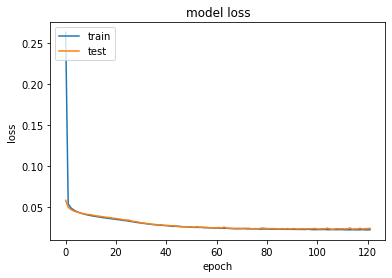

Epoch 1/200
46/46 [==============================] - 3s 25ms/step - loss: 0.4527 - val_loss: 0.0552

Epoch 00001: val_loss improved from inf to 0.05523, saving model to best_model.h5
Epoch 2/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0551 - val_loss: 0.0486

Epoch 00002: val_loss improved from 0.05523 to 0.04858, saving model to best_model.h5
Epoch 3/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0485 - val_loss: 0.0466

Epoch 00003: val_loss improved from 0.04858 to 0.04660, saving model to best_model.h5
Epoch 4/200
46/46 [==============================] - 0s 11ms/step - loss: 0.0471 - val_loss: 0.0451

Epoch 00004: val_loss improved from 0.04660 to 0.04510, saving model to best_model.h5
Epoch 5/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0457 - val_loss: 0.0441

Epoch 00005: val_loss improved from 0.04510 to 0.04409, saving model to best_model.h5
Epoch 6/200
46/46 [==============================] - 1s 11ms/step - l

46/46 [==============================] - 0s 10ms/step - loss: 0.0271 - val_loss: 0.0260

Epoch 00045: val_loss improved from 0.02615 to 0.02595, saving model to best_model.h5
Epoch 46/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0253 - val_loss: 0.0258

Epoch 00046: val_loss improved from 0.02595 to 0.02578, saving model to best_model.h5
Epoch 47/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0266 - val_loss: 0.0257

Epoch 00047: val_loss improved from 0.02578 to 0.02573, saving model to best_model.h5
Epoch 48/200
46/46 [==============================] - 0s 9ms/step - loss: 0.0258 - val_loss: 0.0254

Epoch 00048: val_loss improved from 0.02573 to 0.02545, saving model to best_model.h5
Epoch 49/200
46/46 [==============================] - 1s 13ms/step - loss: 0.0248 - val_loss: 0.0254

Epoch 00049: val_loss improved from 0.02545 to 0.02537, saving model to best_model.h5
Epoch 50/200
46/46 [==============================] - 0s 11ms/step - loss:

46/46 [==============================] - 0s 11ms/step - loss: 0.0244 - val_loss: 0.0238

Epoch 00095: val_loss did not improve from 0.02371
Epoch 96/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0234 - val_loss: 0.0243

Epoch 00096: val_loss did not improve from 0.02371
Epoch 97/200
46/46 [==============================] - 1s 12ms/step - loss: 0.0231 - val_loss: 0.0238

Epoch 00097: val_loss did not improve from 0.02371
Epoch 98/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0237 - val_loss: 0.0239

Epoch 00098: val_loss did not improve from 0.02371
Epoch 99/200
46/46 [==============================] - 0s 11ms/step - loss: 0.0238 - val_loss: 0.0244

Epoch 00099: val_loss did not improve from 0.02371
Epoch 100/200
46/46 [==============================] - 0s 11ms/step - loss: 0.0239 - val_loss: 0.0243

Epoch 00100: val_loss did not improve from 0.02371
Epoch 101/200
46/46 [==============================] - 1s 11ms/step - loss: 0.0242 - val_loss:

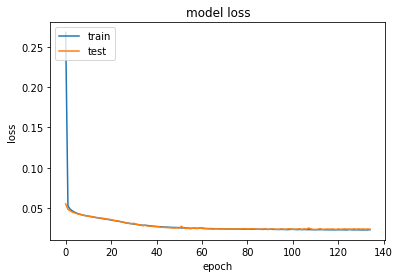

Epoch 1/200
44/44 [==============================] - 3s 21ms/step - loss: 0.4746 - val_loss: 0.0575

Epoch 00001: val_loss improved from inf to 0.05753, saving model to best_model.h5
Epoch 2/200
44/44 [==============================] - 0s 10ms/step - loss: 0.0563 - val_loss: 0.0506

Epoch 00002: val_loss improved from 0.05753 to 0.05064, saving model to best_model.h5
Epoch 3/200
44/44 [==============================] - 0s 11ms/step - loss: 0.0498 - val_loss: 0.0485

Epoch 00003: val_loss improved from 0.05064 to 0.04849, saving model to best_model.h5
Epoch 4/200
44/44 [==============================] - 0s 11ms/step - loss: 0.0494 - val_loss: 0.0470

Epoch 00004: val_loss improved from 0.04849 to 0.04699, saving model to best_model.h5
Epoch 5/200
44/44 [==============================] - 0s 10ms/step - loss: 0.0465 - val_loss: 0.0456

Epoch 00005: val_loss improved from 0.04699 to 0.04562, saving model to best_model.h5
Epoch 6/200
44/44 [==============================] - 0s 11ms/step - l

44/44 [==============================] - 1s 15ms/step - loss: 0.0265 - val_loss: 0.0273

Epoch 00045: val_loss improved from 0.02775 to 0.02725, saving model to best_model.h5
Epoch 46/200
44/44 [==============================] - 1s 15ms/step - loss: 0.0260 - val_loss: 0.0272

Epoch 00046: val_loss improved from 0.02725 to 0.02724, saving model to best_model.h5
Epoch 47/200
44/44 [==============================] - 1s 18ms/step - loss: 0.0266 - val_loss: 0.0273

Epoch 00047: val_loss did not improve from 0.02724
Epoch 48/200
44/44 [==============================] - 1s 19ms/step - loss: 0.0271 - val_loss: 0.0269

Epoch 00048: val_loss improved from 0.02724 to 0.02693, saving model to best_model.h5
Epoch 49/200
44/44 [==============================] - 1s 19ms/step - loss: 0.0264 - val_loss: 0.0273

Epoch 00049: val_loss did not improve from 0.02693
Epoch 50/200
44/44 [==============================] - 1s 17ms/step - loss: 0.0264 - val_loss: 0.0264

Epoch 00050: val_loss improved from 0.026

44/44 [==============================] - 1s 13ms/step - loss: 0.0243 - val_loss: 0.0247

Epoch 00095: val_loss improved from 0.02472 to 0.02467, saving model to best_model.h5
Epoch 96/200
44/44 [==============================] - 1s 12ms/step - loss: 0.0228 - val_loss: 0.0247

Epoch 00096: val_loss improved from 0.02467 to 0.02466, saving model to best_model.h5
Epoch 97/200
44/44 [==============================] - 1s 12ms/step - loss: 0.0235 - val_loss: 0.0249

Epoch 00097: val_loss did not improve from 0.02466
Epoch 98/200
44/44 [==============================] - 1s 12ms/step - loss: 0.0241 - val_loss: 0.0250

Epoch 00098: val_loss did not improve from 0.02466
Epoch 99/200
44/44 [==============================] - 1s 12ms/step - loss: 0.0235 - val_loss: 0.0250

Epoch 00099: val_loss did not improve from 0.02466
Epoch 100/200
44/44 [==============================] - 1s 12ms/step - loss: 0.0246 - val_loss: 0.0251

Epoch 00100: val_loss did not improve from 0.02466
Epoch 101/200
44/44 [===

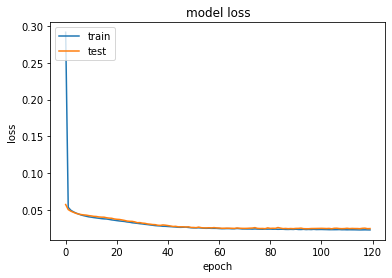

Epoch 1/200
45/45 [==============================] - 3s 24ms/step - loss: 0.5506 - val_loss: 0.0590

Epoch 00001: val_loss improved from inf to 0.05902, saving model to best_model.h5
Epoch 2/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0566 - val_loss: 0.0485

Epoch 00002: val_loss improved from 0.05902 to 0.04849, saving model to best_model.h5
Epoch 3/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0511 - val_loss: 0.0460

Epoch 00003: val_loss improved from 0.04849 to 0.04604, saving model to best_model.h5
Epoch 4/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0481 - val_loss: 0.0448

Epoch 00004: val_loss improved from 0.04604 to 0.04476, saving model to best_model.h5
Epoch 5/200
45/45 [==============================] - 1s 11ms/step - loss: 0.0448 - val_loss: 0.0437

Epoch 00005: val_loss improved from 0.04476 to 0.04375, saving model to best_model.h5
Epoch 6/200
45/45 [==============================] - 0s 11ms/step - l


Epoch 00045: val_loss improved from 0.02828 to 0.02757, saving model to best_model.h5
Epoch 46/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0286 - val_loss: 0.0273

Epoch 00046: val_loss improved from 0.02757 to 0.02727, saving model to best_model.h5
Epoch 47/200
45/45 [==============================] - 1s 11ms/step - loss: 0.0292 - val_loss: 0.0269

Epoch 00047: val_loss improved from 0.02727 to 0.02685, saving model to best_model.h5
Epoch 48/200
45/45 [==============================] - 1s 11ms/step - loss: 0.0284 - val_loss: 0.0266

Epoch 00048: val_loss improved from 0.02685 to 0.02664, saving model to best_model.h5
Epoch 49/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0263 - val_loss: 0.0265

Epoch 00049: val_loss improved from 0.02664 to 0.02646, saving model to best_model.h5
Epoch 50/200
45/45 [==============================] - 1s 11ms/step - loss: 0.0266 - val_loss: 0.0264

Epoch 00050: val_loss improved from 0.02646 to 0.02639, sav

45/45 [==============================] - 1s 16ms/step - loss: 0.0251 - val_loss: 0.0244

Epoch 00093: val_loss did not improve from 0.02382
Epoch 94/200
45/45 [==============================] - 1s 16ms/step - loss: 0.0228 - val_loss: 0.0237

Epoch 00094: val_loss improved from 0.02382 to 0.02374, saving model to best_model.h5
Epoch 95/200
45/45 [==============================] - 1s 14ms/step - loss: 0.0242 - val_loss: 0.0238

Epoch 00095: val_loss did not improve from 0.02374
Epoch 96/200
45/45 [==============================] - 1s 15ms/step - loss: 0.0233 - val_loss: 0.0238

Epoch 00096: val_loss did not improve from 0.02374
Epoch 97/200
45/45 [==============================] - 1s 14ms/step - loss: 0.0242 - val_loss: 0.0237

Epoch 00097: val_loss did not improve from 0.02374
Epoch 98/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0237 - val_loss: 0.0245

Epoch 00098: val_loss did not improve from 0.02374
Epoch 99/200
45/45 [==============================] - 1s 14m

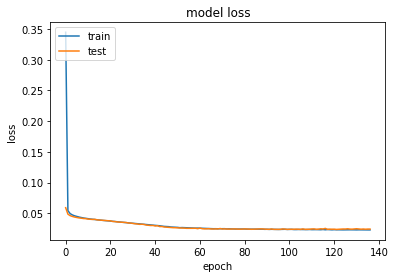

Epoch 1/200
46/46 [==============================] - 4s 28ms/step - loss: 0.4531 - val_loss: 0.0550

Epoch 00001: val_loss improved from inf to 0.05500, saving model to best_model.h5
Epoch 2/200
46/46 [==============================] - 1s 15ms/step - loss: 0.0553 - val_loss: 0.0481

Epoch 00002: val_loss improved from 0.05500 to 0.04810, saving model to best_model.h5
Epoch 3/200
46/46 [==============================] - 1s 13ms/step - loss: 0.0512 - val_loss: 0.0457

Epoch 00003: val_loss improved from 0.04810 to 0.04573, saving model to best_model.h5
Epoch 4/200
46/46 [==============================] - 1s 13ms/step - loss: 0.0470 - val_loss: 0.0441

Epoch 00004: val_loss improved from 0.04573 to 0.04413, saving model to best_model.h5
Epoch 5/200
46/46 [==============================] - 1s 13ms/step - loss: 0.0462 - val_loss: 0.0430

Epoch 00005: val_loss improved from 0.04413 to 0.04298, saving model to best_model.h5
Epoch 6/200
46/46 [==============================] - 1s 13ms/step - l

46/46 [==============================] - 1s 11ms/step - loss: 0.0266 - val_loss: 0.0251

Epoch 00045: val_loss improved from 0.02554 to 0.02506, saving model to best_model.h5
Epoch 46/200
46/46 [==============================] - 0s 11ms/step - loss: 0.0278 - val_loss: 0.0253

Epoch 00046: val_loss did not improve from 0.02506
Epoch 47/200
46/46 [==============================] - 0s 11ms/step - loss: 0.0274 - val_loss: 0.0248

Epoch 00047: val_loss improved from 0.02506 to 0.02481, saving model to best_model.h5
Epoch 48/200
46/46 [==============================] - 1s 12ms/step - loss: 0.0258 - val_loss: 0.0250

Epoch 00048: val_loss did not improve from 0.02481
Epoch 49/200
46/46 [==============================] - 1s 11ms/step - loss: 0.0253 - val_loss: 0.0249

Epoch 00049: val_loss did not improve from 0.02481
Epoch 50/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0257 - val_loss: 0.0245

Epoch 00050: val_loss improved from 0.02481 to 0.02453, saving model to best

46/46 [==============================] - 0s 11ms/step - loss: 0.0225 - val_loss: 0.0224

Epoch 00095: val_loss did not improve from 0.02236
Epoch 96/200
46/46 [==============================] - 1s 12ms/step - loss: 0.0235 - val_loss: 0.0227

Epoch 00096: val_loss did not improve from 0.02236
Epoch 97/200
46/46 [==============================] - 1s 12ms/step - loss: 0.0233 - val_loss: 0.0227

Epoch 00097: val_loss did not improve from 0.02236
Epoch 98/200
46/46 [==============================] - 1s 11ms/step - loss: 0.0214 - val_loss: 0.0228

Epoch 00098: val_loss did not improve from 0.02236
Epoch 99/200
46/46 [==============================] - 1s 11ms/step - loss: 0.0230 - val_loss: 0.0223

Epoch 00099: val_loss improved from 0.02236 to 0.02230, saving model to best_model.h5
Epoch 100/200
46/46 [==============================] - 1s 11ms/step - loss: 0.0238 - val_loss: 0.0225

Epoch 00100: val_loss did not improve from 0.02230
Epoch 101/200
46/46 [==============================] - 0s 1

46/46 [==============================] - 1s 13ms/step - loss: 0.0220 - val_loss: 0.0226

Epoch 00147: val_loss did not improve from 0.02179
Epoch 00147: early stopping


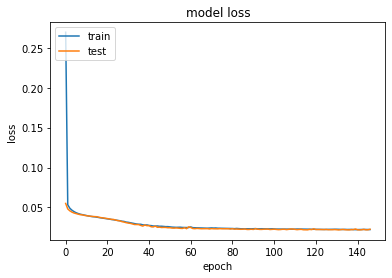

Epoch 1/200
44/44 [==============================] - 3s 24ms/step - loss: 0.4067 - val_loss: 0.0573

Epoch 00001: val_loss improved from inf to 0.05726, saving model to best_model.h5
Epoch 2/200
44/44 [==============================] - 0s 10ms/step - loss: 0.0544 - val_loss: 0.0508

Epoch 00002: val_loss improved from 0.05726 to 0.05077, saving model to best_model.h5
Epoch 3/200
44/44 [==============================] - 0s 11ms/step - loss: 0.0487 - val_loss: 0.0485

Epoch 00003: val_loss improved from 0.05077 to 0.04850, saving model to best_model.h5
Epoch 4/200
44/44 [==============================] - 0s 11ms/step - loss: 0.0428 - val_loss: 0.0471

Epoch 00004: val_loss improved from 0.04850 to 0.04705, saving model to best_model.h5
Epoch 5/200
44/44 [==============================] - 0s 11ms/step - loss: 0.0421 - val_loss: 0.0459

Epoch 00005: val_loss improved from 0.04705 to 0.04589, saving model to best_model.h5
Epoch 6/200
44/44 [==============================] - 0s 10ms/step - l

44/44 [==============================] - 0s 10ms/step - loss: 0.0245 - val_loss: 0.0290

Epoch 00046: val_loss did not improve from 0.02894
Epoch 47/200
44/44 [==============================] - 0s 11ms/step - loss: 0.0238 - val_loss: 0.0293

Epoch 00047: val_loss did not improve from 0.02894
Epoch 48/200
44/44 [==============================] - 0s 11ms/step - loss: 0.0251 - val_loss: 0.0278

Epoch 00048: val_loss improved from 0.02894 to 0.02785, saving model to best_model.h5
Epoch 49/200
44/44 [==============================] - 1s 13ms/step - loss: 0.0240 - val_loss: 0.0280

Epoch 00049: val_loss did not improve from 0.02785
Epoch 50/200
44/44 [==============================] - 1s 13ms/step - loss: 0.0240 - val_loss: 0.0278

Epoch 00050: val_loss improved from 0.02785 to 0.02784, saving model to best_model.h5
Epoch 51/200
44/44 [==============================] - 1s 14ms/step - loss: 0.0239 - val_loss: 0.0275

Epoch 00051: val_loss improved from 0.02784 to 0.02747, saving model to best

44/44 [==============================] - 0s 11ms/step - loss: 0.0234 - val_loss: 0.0257

Epoch 00096: val_loss did not improve from 0.02545
Epoch 97/200
44/44 [==============================] - 1s 12ms/step - loss: 0.0220 - val_loss: 0.0257

Epoch 00097: val_loss did not improve from 0.02545
Epoch 98/200
44/44 [==============================] - 1s 12ms/step - loss: 0.0206 - val_loss: 0.0254

Epoch 00098: val_loss improved from 0.02545 to 0.02542, saving model to best_model.h5
Epoch 99/200
44/44 [==============================] - 1s 11ms/step - loss: 0.0221 - val_loss: 0.0253

Epoch 00099: val_loss improved from 0.02542 to 0.02529, saving model to best_model.h5
Epoch 100/200
44/44 [==============================] - 1s 13ms/step - loss: 0.0224 - val_loss: 0.0259

Epoch 00100: val_loss did not improve from 0.02529
Epoch 101/200
44/44 [==============================] - 1s 12ms/step - loss: 0.0223 - val_loss: 0.0261

Epoch 00101: val_loss did not improve from 0.02529
Epoch 102/200
44/44 [==

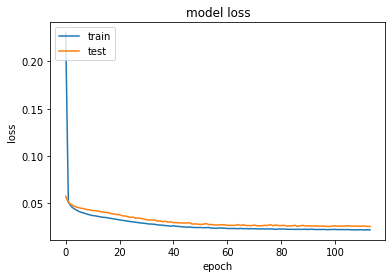

Epoch 1/200
46/46 [==============================] - 4s 26ms/step - loss: 0.4794 - val_loss: 0.0564

Epoch 00001: val_loss improved from inf to 0.05644, saving model to best_model.h5
Epoch 2/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0553 - val_loss: 0.0492

Epoch 00002: val_loss improved from 0.05644 to 0.04921, saving model to best_model.h5
Epoch 3/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0482 - val_loss: 0.0472

Epoch 00003: val_loss improved from 0.04921 to 0.04721, saving model to best_model.h5
Epoch 4/200
46/46 [==============================] - 0s 11ms/step - loss: 0.0467 - val_loss: 0.0457

Epoch 00004: val_loss improved from 0.04721 to 0.04573, saving model to best_model.h5
Epoch 5/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0448 - val_loss: 0.0446

Epoch 00005: val_loss improved from 0.04573 to 0.04459, saving model to best_model.h5
Epoch 6/200
46/46 [==============================] - 0s 10ms/step - l

46/46 [==============================] - 1s 12ms/step - loss: 0.0281 - val_loss: 0.0274

Epoch 00046: val_loss improved from 0.02754 to 0.02743, saving model to best_model.h5
Epoch 47/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0270 - val_loss: 0.0280

Epoch 00047: val_loss did not improve from 0.02743
Epoch 48/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0284 - val_loss: 0.0274

Epoch 00048: val_loss did not improve from 0.02743
Epoch 49/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0272 - val_loss: 0.0268

Epoch 00049: val_loss improved from 0.02743 to 0.02683, saving model to best_model.h5
Epoch 50/200
46/46 [==============================] - 0s 10ms/step - loss: 0.0276 - val_loss: 0.0270

Epoch 00050: val_loss did not improve from 0.02683
Epoch 51/200
46/46 [==============================] - 0s 9ms/step - loss: 0.0258 - val_loss: 0.0269

Epoch 00051: val_loss did not improve from 0.02683
Epoch 52/200
46/46 [======

46/46 [==============================] - 1s 12ms/step - loss: 0.0237 - val_loss: 0.0244

Epoch 00096: val_loss did not improve from 0.02393
Epoch 97/200
46/46 [==============================] - 1s 12ms/step - loss: 0.0242 - val_loss: 0.0245

Epoch 00097: val_loss did not improve from 0.02393
Epoch 98/200
46/46 [==============================] - 1s 12ms/step - loss: 0.0237 - val_loss: 0.0241

Epoch 00098: val_loss did not improve from 0.02393
Epoch 99/200
46/46 [==============================] - 1s 12ms/step - loss: 0.0224 - val_loss: 0.0238

Epoch 00099: val_loss improved from 0.02393 to 0.02383, saving model to best_model.h5
Epoch 100/200
46/46 [==============================] - 1s 12ms/step - loss: 0.0234 - val_loss: 0.0246

Epoch 00100: val_loss did not improve from 0.02383
Epoch 101/200
46/46 [==============================] - 1s 12ms/step - loss: 0.0242 - val_loss: 0.0244

Epoch 00101: val_loss did not improve from 0.02383
Epoch 102/200
46/46 [==============================] - 1s 

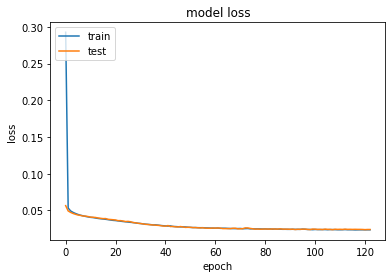

Epoch 1/200
45/45 [==============================] - 4s 34ms/step - loss: 0.4807 - val_loss: 0.0579

Epoch 00001: val_loss improved from inf to 0.05791, saving model to best_model.h5
Epoch 2/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0526 - val_loss: 0.0506

Epoch 00002: val_loss improved from 0.05791 to 0.05056, saving model to best_model.h5
Epoch 3/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0494 - val_loss: 0.0485

Epoch 00003: val_loss improved from 0.05056 to 0.04845, saving model to best_model.h5
Epoch 4/200
45/45 [==============================] - 1s 14ms/step - loss: 0.0463 - val_loss: 0.0472

Epoch 00004: val_loss improved from 0.04845 to 0.04724, saving model to best_model.h5
Epoch 5/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0479 - val_loss: 0.0461

Epoch 00005: val_loss improved from 0.04724 to 0.04610, saving model to best_model.h5
Epoch 6/200
45/45 [==============================] - 1s 13ms/step - l

45/45 [==============================] - 1s 13ms/step - loss: 0.0277 - val_loss: 0.0280

Epoch 00045: val_loss improved from 0.02806 to 0.02799, saving model to best_model.h5
Epoch 46/200
45/45 [==============================] - 1s 15ms/step - loss: 0.0262 - val_loss: 0.0281

Epoch 00046: val_loss did not improve from 0.02799
Epoch 47/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0249 - val_loss: 0.0279

Epoch 00047: val_loss improved from 0.02799 to 0.02792, saving model to best_model.h5
Epoch 48/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0264 - val_loss: 0.0273

Epoch 00048: val_loss improved from 0.02792 to 0.02733, saving model to best_model.h5
Epoch 49/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0248 - val_loss: 0.0285

Epoch 00049: val_loss did not improve from 0.02733
Epoch 50/200
45/45 [==============================] - 1s 15ms/step - loss: 0.0271 - val_loss: 0.0271

Epoch 00050: val_loss improved from 0.027


Epoch 00094: val_loss did not improve from 0.02539
Epoch 95/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0231 - val_loss: 0.0259

Epoch 00095: val_loss did not improve from 0.02539
Epoch 96/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0245 - val_loss: 0.0258

Epoch 00096: val_loss did not improve from 0.02539
Epoch 97/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0233 - val_loss: 0.0261

Epoch 00097: val_loss did not improve from 0.02539
Epoch 98/200
45/45 [==============================] - 1s 14ms/step - loss: 0.0237 - val_loss: 0.0258

Epoch 00098: val_loss did not improve from 0.02539
Epoch 99/200
45/45 [==============================] - 0s 11ms/step - loss: 0.0225 - val_loss: 0.0258

Epoch 00099: val_loss did not improve from 0.02539
Epoch 100/200
45/45 [==============================] - 0s 10ms/step - loss: 0.0228 - val_loss: 0.0257

Epoch 00100: val_loss did not improve from 0.02539
Epoch 00100: early stopping


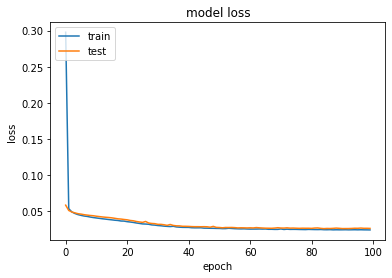

Epoch 1/200
45/45 [==============================] - 3s 23ms/step - loss: 0.5727 - val_loss: 0.0700

Epoch 00001: val_loss improved from inf to 0.06998, saving model to best_model.h5
Epoch 2/200
45/45 [==============================] - 0s 11ms/step - loss: 0.0628 - val_loss: 0.0503

Epoch 00002: val_loss improved from 0.06998 to 0.05035, saving model to best_model.h5
Epoch 3/200
45/45 [==============================] - 1s 11ms/step - loss: 0.0499 - val_loss: 0.0475

Epoch 00003: val_loss improved from 0.05035 to 0.04749, saving model to best_model.h5
Epoch 4/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0503 - val_loss: 0.0458

Epoch 00004: val_loss improved from 0.04749 to 0.04582, saving model to best_model.h5
Epoch 5/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0492 - val_loss: 0.0447

Epoch 00005: val_loss improved from 0.04582 to 0.04475, saving model to best_model.h5
Epoch 6/200
45/45 [==============================] - 1s 12ms/step - l

45/45 [==============================] - 1s 13ms/step - loss: 0.0275 - val_loss: 0.0272

Epoch 00045: val_loss improved from 0.02774 to 0.02718, saving model to best_model.h5
Epoch 46/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0280 - val_loss: 0.0271

Epoch 00046: val_loss improved from 0.02718 to 0.02708, saving model to best_model.h5
Epoch 47/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0260 - val_loss: 0.0269

Epoch 00047: val_loss improved from 0.02708 to 0.02693, saving model to best_model.h5
Epoch 48/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0262 - val_loss: 0.0277

Epoch 00048: val_loss did not improve from 0.02693
Epoch 49/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0262 - val_loss: 0.0264

Epoch 00049: val_loss improved from 0.02693 to 0.02643, saving model to best_model.h5
Epoch 50/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0255 - val_loss: 0.0261

Epoch 

45/45 [==============================] - 1s 13ms/step - loss: 0.0222 - val_loss: 0.0245

Epoch 00094: val_loss did not improve from 0.02400
Epoch 95/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0241 - val_loss: 0.0243

Epoch 00095: val_loss did not improve from 0.02400
Epoch 96/200
45/45 [==============================] - 1s 11ms/step - loss: 0.0237 - val_loss: 0.0240

Epoch 00096: val_loss did not improve from 0.02400
Epoch 97/200
45/45 [==============================] - 1s 14ms/step - loss: 0.0231 - val_loss: 0.0245

Epoch 00097: val_loss did not improve from 0.02400
Epoch 98/200
45/45 [==============================] - 0s 11ms/step - loss: 0.0245 - val_loss: 0.0241

Epoch 00098: val_loss did not improve from 0.02400
Epoch 99/200
45/45 [==============================] - 0s 10ms/step - loss: 0.0229 - val_loss: 0.0241

Epoch 00099: val_loss did not improve from 0.02400
Epoch 100/200
45/45 [==============================] - 0s 11ms/step - loss: 0.0244 - val_loss: 

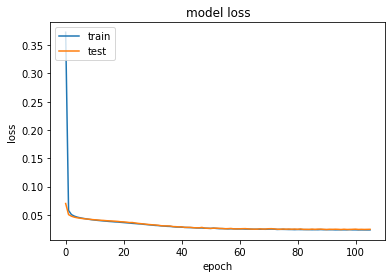

In [25]:
data_subset = df[['seconds_since_last_action', 'label']]
inputdf = pd.concat([df[['assignment_log_id', 'student_user_xid']], pd.get_dummies(df['extended_action_name']), data_subset], axis=1)

# Call model.fit 10 times and output predictions and actual values (calculate metrics later: auc, kappa, recall)
# Call model.predict passing in test
X_train_predict, X_test_predict = [], []
X_train, Y_train = [None for i in range(10)], [None for i in range(10)]
X_test, Y_test = [None for i in range(10)], [None for i in range(10)]

# inputs = keras.Input(shape=(None, input_cols), dtype="float32")

for i in range(0, 10):
    test, train = holdout_split(i, inputdf)
    X_train[i], Y_train[i] = create_xy(train)
    X_test[i], Y_test[i] = create_xy(test) 

for i in range(0, 10):
    lstm_model = keras.Sequential([
        keras.layers.LSTM(n_units, input_shape=(None, input_cols), return_sequences=True), 
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # Notes: binary cross entropy loss function, optimization: adam or adagrad
    lstm_model.compile(
        loss='binary_crossentropy',
        optimizer='adam'
    )
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    
    history = lstm_model.fit(
        tf.keras.preprocessing.sequence.pad_sequences(X_train[i], padding='post'), # TODO: Does this need to get padded to 249?
        tf.keras.preprocessing.sequence.pad_sequences(Y_train[i], padding='post'),
        epochs=n_epochs,
        batch_size=batch_size,
        validation_split=val_split,
        callbacks=[es, mc]
    )

    saved_model = load_model('best_model.h5')
#     X_train_predict.append(lstm_model.predict(tf.keras.preprocessing.sequence.pad_sequences(X_train)))
    X_test_predict.append(saved_model.predict(tf.keras.preprocessing.sequence.pad_sequences(X_test[i])))
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [26]:
# Flatten and remove post padding
Y_flattened = []
for i in range(10):
#     print("Base length:", len(Y_test[i]))
    Y_test_flat = np.array([])
    for seq in Y_test[i]:
        Y_test_flat = np.append(Y_test_flat,seq.ravel())
#     Y_flattened.append(Y_test_flat.reshape((-1,1)))
    Y_flattened.append(Y_test_flat)

#     print("Flattened length:", len(Y_test_flat.reshape((-1,1))))
#     print("First sequence:", len(Y_test_flat.reshape((-1,1))) / len(Y_test[i]))
#     print("First length:", len(Y_test[i][0]))
#     print()

In [27]:
for i in range(10):
#     print("Base length:", len(X_test_predict[i]))
    predict_test_flat = np.array([])
    for seq in X_test_predict[i]:
        predict_test_flat = np.append(predict_test_flat, seq.ravel())
    predict_test_flat.reshape((-1,1))
#     print("Flattened length:", len(predict_test_flat.reshape((-1,1))))
#     print("Per sequence:", len(predict_test_flat.reshape((-1,1))) / len(X_test_predict[i]))
#     print("First length:", len(X_test_predict[i][0]))
#     print()

In [28]:
predict_unpadded = []
for i in range(len(Y_test)):
    predict = np.array([])
    for j in range(len(Y_test[i])):
        unpadded_length = len(Y_test[i][j])
        predict = np.append(predict, X_test_predict[i][j][:unpadded_length])
    predict_unpadded.append(predict)

In [29]:
len(Y_flattened[0]), len(predict_unpadded[0])

(684, 684)

In [30]:
for i in range(10):
    fpr, tpr, thresholds = metrics.roc_curve(Y_flattened[i], predict_unpadded[i])
    print('Test Score: %.2f AUC' % (metrics.auc(fpr, tpr)))

Test Score: 0.64 AUC
Test Score: 0.59 AUC
Test Score: 0.61 AUC
Test Score: 0.58 AUC
Test Score: 0.61 AUC
Test Score: 0.67 AUC
Test Score: 0.63 AUC
Test Score: 0.57 AUC
Test Score: 0.63 AUC
Test Score: 0.65 AUC


In [31]:
for i in range(10):
    kappa = metrics.cohen_kappa_score(Y_flattened[i], np.where(predict_unpadded[i] > 0.5, 1, 0))
    print('Test Score: %f Kappa' % kappa)

Test Score: 0.000000 Kappa
Test Score: 0.000000 Kappa
Test Score: 0.000000 Kappa
Test Score: 0.000000 Kappa
Test Score: 0.000000 Kappa
Test Score: 0.000000 Kappa
Test Score: -0.003678 Kappa
Test Score: 0.000000 Kappa
Test Score: 0.000000 Kappa
Test Score: 0.000000 Kappa
